# 01b - Exploratory Data Analysis: Raw Data

This notebook performs EDA on the raw harvested metadata to identify data quality issues before cleaning.

## Analysis Overview
- Dataset overview (shape, columns, dtypes)
- Missing value analysis
- Duplicate detection
- Text field statistics
- Date range and distribution
- Subject/keyword frequency
- Identify issues to address in cleaning

In [1]:
# Import required libraries
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.config import get_settings

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [2]:
# Load settings and data
settings = get_settings()
data_path = settings.raw_data_dir / settings.raw_metadata_file

print(f"Loading data from: {data_path}")
df = pd.read_csv(data_path)
print(f"Loaded {len(df)} records")

Loading data from: c:\Users\alifn\Code\topic-modeling-utama\data\raw\raw_metadata.csv
Loaded 12647 records


## 1. Dataset Overview

In [3]:
# Basic info
print("Dataset Shape:", df.shape)
print(f"\nTotal records: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print("\nColumns and data types:")
print("-" * 50)
df.info()

Dataset Shape: (12647, 10)

Total records: 12,647
Total columns: 10

Columns and data types:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12647 entries, 0 to 12646
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   identifier  12647 non-null  object 
 1   title       12647 non-null  object 
 2   abstract    12488 non-null  object 
 3   authors     12637 non-null  object 
 4   date        12647 non-null  object 
 5   subjects    11342 non-null  object 
 6   publisher   12543 non-null  object 
 7   types       12489 non-null  object 
 8   language    10246 non-null  object 
 9   source      0 non-null      float64
dtypes: float64(1), object(9)
memory usage: 988.2+ KB


In [4]:
# Display sample records
df.head()

,identifier,title,abstract,authors,date,subjects,publisher,types,language,source
0,oai:repository.widyatama.ac.id:123456789/14397,PENGARUH BUDAYA KESELAMATAN DAN KESEHATAN KERJ...,Tujuan penelitian ini adalah untuk mengetahui ...,"Falyana, Diki Hendra",2022-01-05T05:10:37Z,budaya keselamatan dan kesehatan (K3); prosedu...,Program Studi Manajemen S1 Universitas Widyatama,Thesis,other,NaN
1,oai:repository.widyatama.ac.id:123456789/859,Pengaruh Kompensasi terhadap Motivasi Kerja Ka...,"Skripsi ini disusun oleh Andri Tanjung, NRP 02...","Tanjung, Andri",2009-03-11T02:35:44Z,Pengaruh Kompensasi terhadap Motivasi Kerja Ka...,Universitas Widyatama,Thesis,other,NaN
2,oai:repository.widyatama.ac.id:123456789/5337,PERANAN SISTEM INFORMASI AKUNTANSI DALAM MENUN...,Setiap organisasi didirikan untuk mencapai tuj...,"Setiawan, David",2015-06-17T06:18:20Z,Sistem Informasi Akuntansi; Pengendalian Inter...,Universitas Widyatama,Thesis,other,NaN
3,oai:repository.widyatama.ac.id:123456789/107890,PENGARUH USIA DAN MASA KERJA TERHADAP PRODUKTI...,Penelitian ini bertujuan untuk mengetahui peng...,"Fauzia, Galih Eza",2024-04-25T03:35:03Z,NaN,NaN,Thesis,other,NaN
4,oai:repository.widyatama.ac.id:123456789/8665,PENGARUH SISTEM PENGENDALIAN INTERNAL PEMERINT...,Penelitian ini bertujuan untuk mengetahui peng...,"Aruan, Hicca Maria Gandi Putri",2017-10-18T23:53:16Z,Sistem Pengendalian Internal Pemerintah; Kuali...,Universitas Widyatama,Thesis,other,NaN


## 2. Missing Value Analysis

In [5]:
# Missing values summary
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing %': (df.isnull().sum() / len(df) * 100).values,
    'Non-null Count': df.notnull().sum().values,
})
missing_df = missing_df.sort_values('Missing %', ascending=False)
missing_df

,Column,Missing Count,Missing %,Non-null Count
9,source,12647,100.000000,0
8,language,2401,18.984739,10246
5,subjects,1305,10.318653,11342
2,abstract,159,1.257215,12488
7,types,158,1.249308,12489
6,publisher,104,0.822329,12543
3,authors,10,0.079070,12637
0,identifier,0,0.000000,12647
1,title,0,0.000000,12647
4,date,0,0.000000,12647


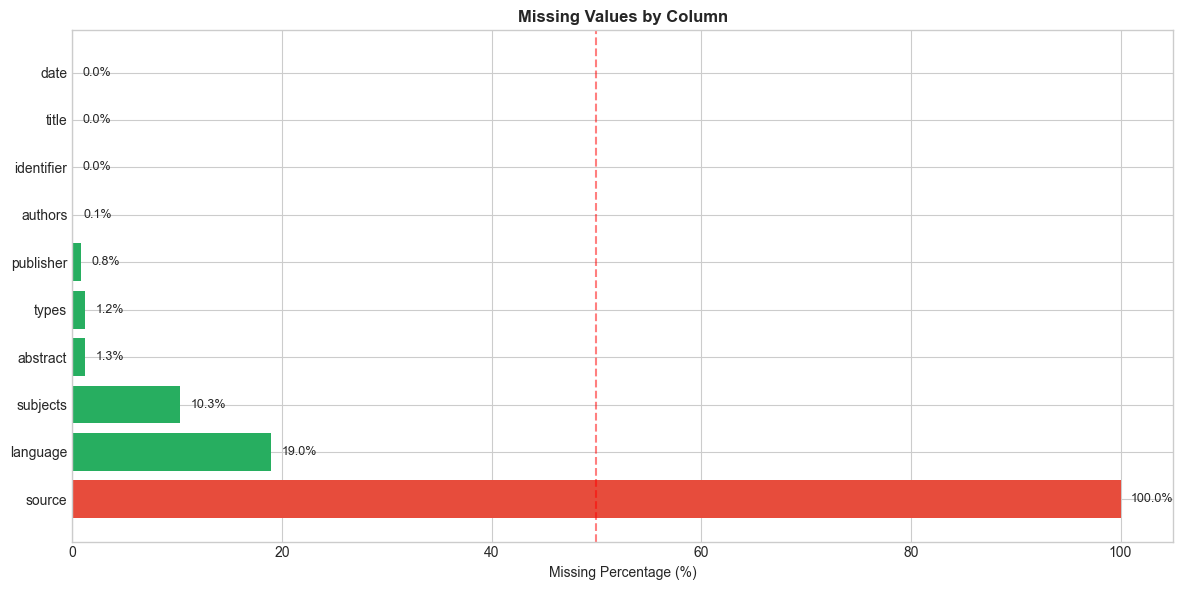

In [6]:
# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#e74c3c' if pct > 50 else '#f39c12' if pct > 20 else '#27ae60' 
          for pct in missing_df['Missing %']]

bars = ax.barh(missing_df['Column'], missing_df['Missing %'], color=colors)
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Missing Values by Column', fontweight='bold')
ax.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')

# Add percentage labels
for bar, pct in zip(bars, missing_df['Missing %']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Duplicate Analysis

In [7]:
# Check for duplicates
print("Duplicate Analysis:")
print("-" * 50)

# Exact duplicates
exact_dups = df.duplicated().sum()
print(f"Exact duplicates (all columns): {exact_dups} ({exact_dups/len(df)*100:.2f}%)")

# Duplicate identifiers
id_dups = df['identifier'].duplicated().sum()
print(f"Duplicate identifiers: {id_dups} ({id_dups/len(df)*100:.2f}%)")

# Duplicate titles
title_dups = df['title'].duplicated().sum()
print(f"Duplicate titles: {title_dups} ({title_dups/len(df)*100:.2f}%)")

# Check for duplicate abstracts
abstract_dups = df['abstract'].duplicated().sum()
print(f"Duplicate abstracts: {abstract_dups} ({abstract_dups/len(df)*100:.2f}%)")

Duplicate Analysis:
--------------------------------------------------
Exact duplicates (all columns): 0 (0.00%)
Duplicate identifiers: 0 (0.00%)
Duplicate titles: 125 (0.99%)
Duplicate abstracts: 502 (3.97%)


In [8]:
# Show some duplicate titles if any
if title_dups > 0:
    dup_titles = df[df['title'].duplicated(keep=False)]['title'].value_counts().head(10)
    print("\nMost common duplicate titles:")
    for title, count in dup_titles.items():
        print(f"  [{count}x] {title[:80]}..." if len(str(title)) > 80 else f"  [{count}x] {title}")


# Show some duplicate abstracts if any
if abstract_dups > 0:
    dup_abstracts = df[df['abstract'].duplicated(keep=False)]['abstract'].value_counts().head(10)
    print("\nMost common duplicate abstracts:")
    for abstract, count in dup_abstracts.items():
        print(f"  [{count}x] {abstract[:80]}..." if len(str(abstract)) > 80 else f"  [{count}x] {abstract}")



Most common duplicate titles:
  [3x] Optimasi Pengendalian Persediaan Suku Cadang Kritis Bis Berdasarkan Laju Kerusak...
  [3x] TINJAUAN ATAS PENYUSUNAN ANGGARAN KAS PADA KOPERASI PEGAWAI PEMERINTAH KOTA BAND...
  [3x] IDENTIFIKASI KEMEMARAN BUAH APEL MENGGUNAKAN EKSTRAKSI CIRI GLCM DAN KLASIFIKASI...
  [3x] PERANCANGAN FILM FIKSI PENDEK BERJUDUL SASAK PANGIRIMAN
  [3x] TINJAUAN ATAS ANALISIS SUMBER DAN PENGGUNAAN KAS PADA SWALAYAN FARMASI PT.KIMIA ...
  [2x] ANALISIS PERBANDINGAN TINGKAT KESEHATAN BANK SEBELUM DAN SETELAH MERGER (Studi k...
  [2x] EVALUASI PENERAPAN TRANSFER PRICING PADA PT X
  [2x] PENGARUH PROFITABILITAS, LEVERAGE, DAN UKURAN PERUSAHAAN TERHADAP PENGUNGKAPAN S...
  [2x] TINJAUAN BAURAN PEMASARAN PRODUK KCA (KREDIT CEPAT DAN AMAN) YANG DILAKUKAN OLEH...
  [2x] PENGARUH PENERAPAN AKUNTANSI MANAJEMEN LINGKUNGAN TERHADAP INOVASI PRODUK (Surve...

Most common duplicate abstracts:
  [239x] -
  [3x] Universitas Widyatama - Fakultas Ekonomi
  [3x] Identifikasi memar adalah

## 4. Text Field Statistics

In [9]:
# Calculate text lengths
df['title_length'] = df['title'].fillna('').str.len()
df['abstract_length'] = df['abstract'].fillna('').str.len()
df['abstract_word_count'] = df['abstract'].fillna('').str.split().str.len()

# Title statistics
print("Title Length Statistics:")
print(df['title_length'].describe())

Title Length Statistics:
count    12647.000000
mean       131.289476
std         43.993489
min         19.000000
25%         99.000000
50%        126.000000
75%        160.000000
max        579.000000
Name: title_length, dtype: float64


In [10]:
# Abstract statistics
print("Abstract Length Statistics:")
print(df['abstract_length'].describe())

print("\nAbstract Word Count Statistics:")
print(df['abstract_word_count'].describe())

Abstract Length Statistics:
count    12647.000000
mean      1616.524314
std        647.401762
min          0.000000
25%       1213.000000
50%       1537.000000
75%       1990.000000
max      13034.000000
Name: abstract_length, dtype: float64

Abstract Word Count Statistics:
count    12647.000000
mean       208.975251
std         85.239400
min          0.000000
25%        156.000000
50%        198.000000
75%        258.000000
max       1700.000000
Name: abstract_word_count, dtype: float64


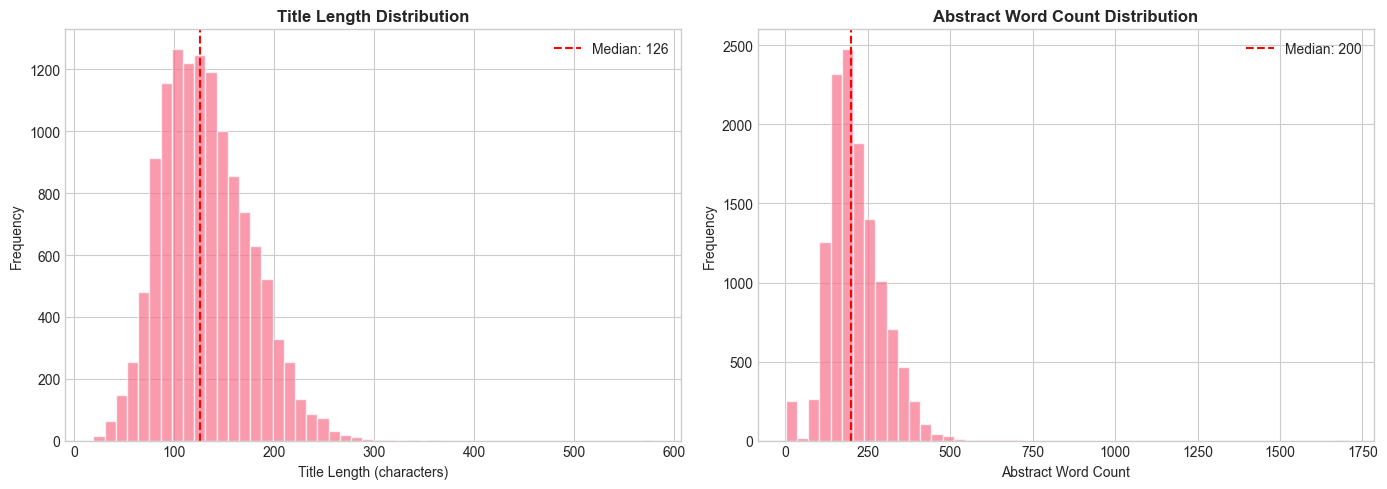

In [11]:
# Visualize text length distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Title length distribution
axes[0].hist(df['title_length'], bins=50, edgecolor='white', alpha=0.7)
axes[0].set_xlabel('Title Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Title Length Distribution', fontweight='bold')
axes[0].axvline(df['title_length'].median(), color='red', linestyle='--', label=f'Median: {df["title_length"].median():.0f}')
axes[0].legend()

# Abstract word count distribution
abstract_words = df[df['abstract_word_count'] > 0]['abstract_word_count']
axes[1].hist(abstract_words, bins=50, edgecolor='white', alpha=0.7)
axes[1].set_xlabel('Abstract Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Abstract Word Count Distribution', fontweight='bold')
axes[1].axvline(abstract_words.median(), color='red', linestyle='--', label=f'Median: {abstract_words.median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# Empty/very short abstracts
short_threshold = 50
short_abstracts = df[df['abstract_word_count'] < short_threshold]
print(f"\nRecords with short abstracts (<{short_threshold} words): {len(short_abstracts)} ({len(short_abstracts)/len(df)*100:.1f}%)")

empty_abstracts = df[df['abstract'].isna() | (df['abstract'] == '')]
print(f"Records with empty abstracts: {len(empty_abstracts)} ({len(empty_abstracts)/len(df)*100:.1f}%)")


Records with short abstracts (<50 words): 414 (3.3%)
Records with empty abstracts: 159 (1.3%)


## 5. Date Analysis

In [13]:
# Parse dates
df['parsed_date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['parsed_date'].dt.year

# Date parsing success rate
valid_dates = df['parsed_date'].notna().sum()
print(f"Valid parsed dates: {valid_dates} ({valid_dates/len(df)*100:.1f}%)")
print(f"Invalid/unparseable dates: {len(df) - valid_dates}")

# Date range
if valid_dates > 0:
    print(f"\nDate range: {df['parsed_date'].min()} to {df['parsed_date'].max()}")

Valid parsed dates: 12647 (100.0%)
Invalid/unparseable dates: 0

Date range: 2007-11-19 01:40:55+00:00 to 2025-12-12 07:18:56+00:00


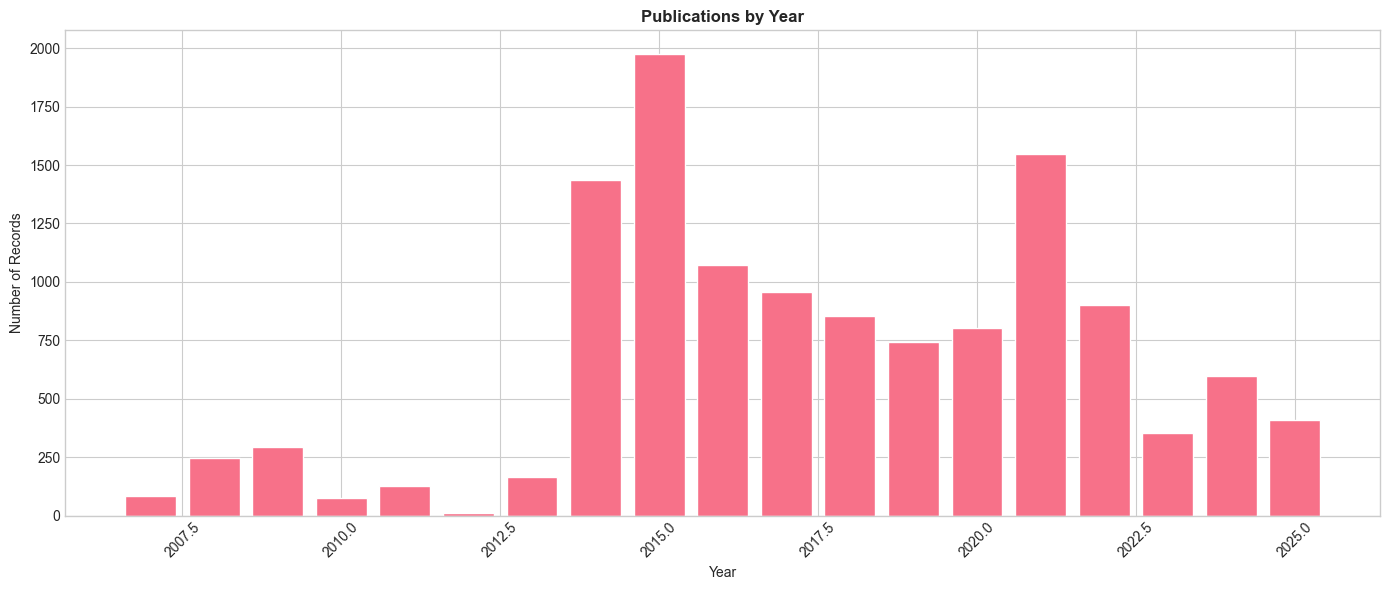

In [14]:
# Year distribution
if valid_dates > 0:
    year_counts = df['year'].value_counts().sort_index()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(year_counts.index, year_counts.values, edgecolor='white')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Records')
    ax.set_title('Publications by Year', fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [15]:
# Unparseable date samples
invalid_dates = df[df['parsed_date'].isna()]['date'].dropna().head(10)
if len(invalid_dates) > 0:
    print("Sample unparseable dates:")
    for d in invalid_dates:
        print(f"  '{d}'")

## 6. Subject/Keyword Analysis

In [16]:
# Analyze subjects
subjects_with_data = df[df['subjects'].notna() & (df['subjects'] != '')]
print(f"Records with subjects: {len(subjects_with_data)} ({len(subjects_with_data)/len(df)*100:.1f}%)")

# Count all subjects
all_subjects = []
for subj_str in subjects_with_data['subjects']:
    # Subjects are separated by '; '
    subjects = [s.strip() for s in str(subj_str).split(';')]
    all_subjects.extend(subjects)

subject_counts = Counter(all_subjects)
print(f"\nTotal unique subjects: {len(subject_counts)}")

Records with subjects: 11342 (89.7%)

Total unique subjects: 17658


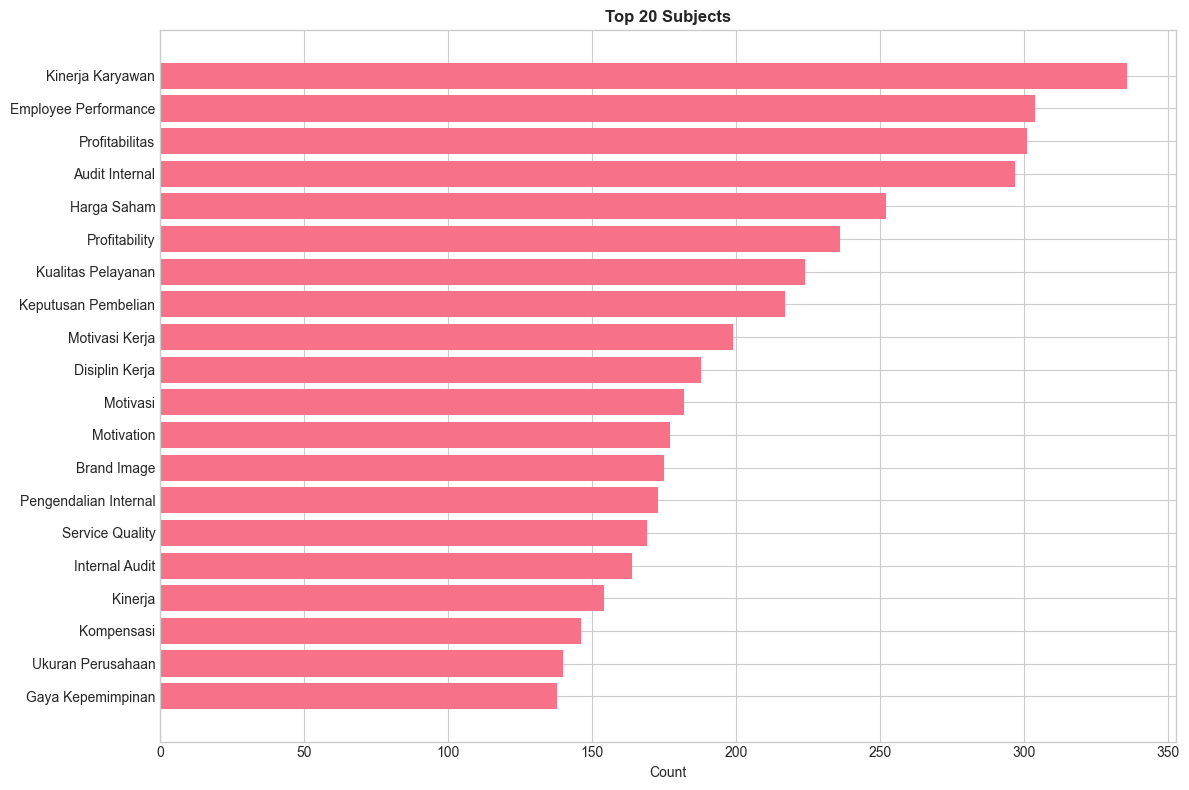

In [17]:
# Top subjects
top_subjects = subject_counts.most_common(20)

if top_subjects:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    subjects = [s[0][:40] + '...' if len(s[0]) > 40 else s[0] for s in top_subjects]
    counts = [s[1] for s in top_subjects]
    
    ax.barh(range(len(subjects)), counts)
    ax.set_yticks(range(len(subjects)))
    ax.set_yticklabels(subjects)
    ax.invert_yaxis()
    ax.set_xlabel('Count')
    ax.set_title('Top 20 Subjects', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 7. Language Detection (Sample)

In [18]:
# Check language field if available
if 'language' in df.columns:
    lang_counts = df['language'].value_counts()
    print("Language distribution:")
    print(lang_counts)

Language distribution:
language
other        10059
Indonesia      173
en               8
english          3
it               1
en_US            1
fr               1
Name: count, dtype: int64


In [19]:
# Simple language detection based on common words
def detect_language_simple(text):
    if pd.isna(text) or text == '':
        return 'unknown'
    
    text_lower = str(text).lower()
    
    # Indonesian indicators
    id_words = ['yang', 'dan', 'dengan', 'untuk', 'adalah', 'dalam', 'pada', 'dari']
    # English indicators  
    en_words = ['the', 'and', 'with', 'for', 'this', 'that', 'from', 'are']
    
    id_count = sum(1 for w in id_words if f' {w} ' in f' {text_lower} ')
    en_count = sum(1 for w in en_words if f' {w} ' in f' {text_lower} ')
    
    if id_count > en_count:
        return 'indonesian'
    elif en_count > id_count:
        return 'english'
    else:
        return 'mixed/unknown'

# Apply to abstracts
df['detected_language'] = df['abstract'].apply(detect_language_simple)
lang_dist = df['detected_language'].value_counts()

print("Detected language distribution (abstracts):")
for lang, count in lang_dist.items():
    print(f"  {lang}: {count} ({count/len(df)*100:.1f}%)")

Detected language distribution (abstracts):
  indonesian: 11964 (94.6%)
  english: 273 (2.2%)
  mixed/unknown: 251 (2.0%)
  unknown: 159 (1.3%)


## 8. Summary of Issues to Address

Based on the EDA, here are the data quality issues to address in the cleaning notebook:

In [20]:
print("📋 DATA QUALITY SUMMARY")
print("=" * 60)

issues = []

# Missing values
for col in ['title', 'abstract', 'date', 'authors']:
    missing_pct = df[col].isna().sum() / len(df) * 100
    if missing_pct > 5:
        issues.append(f"High missing rate in '{col}': {missing_pct:.1f}%")

# Duplicates
if title_dups > 0:
    issues.append(f"Duplicate titles: {title_dups} records")
if abstract_dups > 0:
    issues.append(f"Duplicate abstracts: {abstract_dups} records")

# Short abstracts
short_count = len(df[df['abstract_word_count'] < 20])
if short_count > 0:
    issues.append(f"Very short abstracts (<20 words): {short_count} records")

# Print issues
if issues:
    print("\n⚠️  Issues to address in cleaning:")
    for i, issue in enumerate(issues, 1):
        print(f"   {i}. {issue}")
else:
    print("\n✅ No major issues detected!")

print("\n" + "=" * 60)
print(f"\n📊 Dataset: {len(df):,} records")
print(f"📅 Date range: {df['year'].min():.0f} - {df['year'].max():.0f}" if df['year'].notna().any() else "Date range: Unknown")
print(f"🌐 Primary language: {df['detected_language'].mode().iloc[0] if len(df['detected_language'].mode()) > 0 else 'Unknown'}")

📋 DATA QUALITY SUMMARY

⚠️  Issues to address in cleaning:
   1. Duplicate titles: 125 records
   2. Duplicate abstracts: 502 records
   3. Very short abstracts (<20 words): 411 records


📊 Dataset: 12,647 records
📅 Date range: 2007 - 2025
🌐 Primary language: indonesian


In [21]:
# Clean up temporary columns before saving
temp_cols = ['title_length', 'abstract_length', 'abstract_word_count', 'parsed_date', 'year', 'detected_language']
df_original = df.drop(columns=temp_cols, errors='ignore')

print(f"\n👉 Next: Run 02_data_cleaning.ipynb to clean the data")
print(f"   Based on the issues identified above")


👉 Next: Run 02_data_cleaning.ipynb to clean the data
   Based on the issues identified above
